<a href="https://colab.research.google.com/github/rohinish404/learning_pytorch/blob/master/pytorch_classification_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles
n_samples = 1000
X,y = make_circles(n_samples,
                   noise = 0.03,
                   random_state=42)

In [3]:
len(X)

1000

In [4]:
X[:10]

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       [-0.39373073,  0.69288277],
       [ 0.44220765, -0.89672343],
       [-0.47964637,  0.67643477],
       [-0.01364836,  0.80334872],
       [ 0.77151327,  0.14775959],
       [-0.16932234, -0.79345575],
       [-0.1214858 ,  1.02150905]])

In [5]:
y[:10]

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0])

In [6]:
import pandas as pd
circles = pd.DataFrame({"X1" : X[:,0],
                        "X2" : X[:,1],
                        "label":y})

In [7]:
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


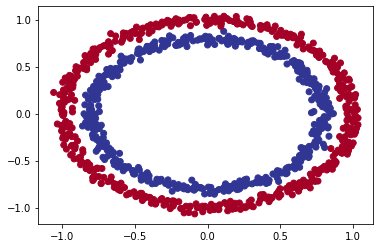

In [8]:
import matplotlib.pyplot as plt
plt.scatter(x = X[:,0],
            y= X[:,1],
            c=y,
            cmap = plt.cm.RdYlBu)

In [9]:
import torch 
torch.__version__

'1.13.1+cu116'

In [10]:
type(X)

numpy.ndarray

In [11]:
X = torch.from_numpy(X).type(torch.float)
y= torch.from_numpy(y).type(torch.float)

In [12]:
X[:5]

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]])

In [13]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=42)

In [14]:
len(X_train)

800

In [15]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [16]:
from sklearn import datasets

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features = 2,out_features = 5)
    self.layer_2 = nn.Linear(in_features = 5,out_features = 1)


  def forward(self,x):
    return self.layer_2(self.layer_1(x)) 


model_0 = CircleModelV0().to(device)
model_0


CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
device

'cuda'

In [18]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
model_0.state_dict()

OrderedDict([('0.weight', tensor([[-0.0592,  0.1050],
                      [-0.2335, -0.1712],
                      [-0.1925,  0.1132],
                      [-0.0907,  0.1775],
                      [ 0.3834, -0.6603]], device='cuda:0')),
             ('0.bias',
              tensor([-0.2995, -0.1771, -0.1588, -0.3642, -0.1005], device='cuda:0')),
             ('1.weight',
              tensor([[-0.4100,  0.3175, -0.1165,  0.3632,  0.2710]], device='cuda:0')),
             ('1.bias', tensor([0.3228], device='cuda:0'))])

In [20]:
untrained_preds = model_0(X_test.to(device))

In [21]:
len(untrained_preds)

200

In [22]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr=0.1)

In [23]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc


In [24]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]

y_logits  

tensor([[0.0784],
        [0.0330],
        [0.2886],
        [0.0185],
        [0.4333]], device='cuda:0')

In [25]:
y_preds_probs = torch.sigmoid(y_logits)
y_preds_probs

tensor([[0.5196],
        [0.5082],
        [0.5717],
        [0.5046],
        [0.6067]], device='cuda:0')

In [26]:
y_preds = torch.round(y_preds_probs)

In [27]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  y_logits = model_0(X_train.to(device)).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,y_train)

  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)
  

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))


    test_loss =  loss_fn(test_logits,y_test)
    test_acc =  accuracy_fn(y_true = y_test,
                    y_pred = test_pred)
    

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")    

Epoch: 0 | Loss: 0.70484, Accuracy: 50.00% | Test loss: 0.69764, Test acc: 50.00%
Epoch: 10 | Loss: 0.69933, Accuracy: 57.75% | Test loss: 0.69364, Test acc: 60.50%
Epoch: 20 | Loss: 0.69681, Accuracy: 53.37% | Test loss: 0.69211, Test acc: 53.50%
Epoch: 30 | Loss: 0.69557, Accuracy: 51.62% | Test loss: 0.69159, Test acc: 53.50%
Epoch: 40 | Loss: 0.69489, Accuracy: 51.00% | Test loss: 0.69146, Test acc: 53.00%
Epoch: 50 | Loss: 0.69447, Accuracy: 50.12% | Test loss: 0.69150, Test acc: 53.00%
Epoch: 60 | Loss: 0.69419, Accuracy: 50.12% | Test loss: 0.69161, Test acc: 53.50%
Epoch: 70 | Loss: 0.69397, Accuracy: 49.62% | Test loss: 0.69174, Test acc: 54.00%
Epoch: 80 | Loss: 0.69381, Accuracy: 49.38% | Test loss: 0.69188, Test acc: 54.00%
Epoch: 90 | Loss: 0.69368, Accuracy: 49.38% | Test loss: 0.69202, Test acc: 53.50%


In [28]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

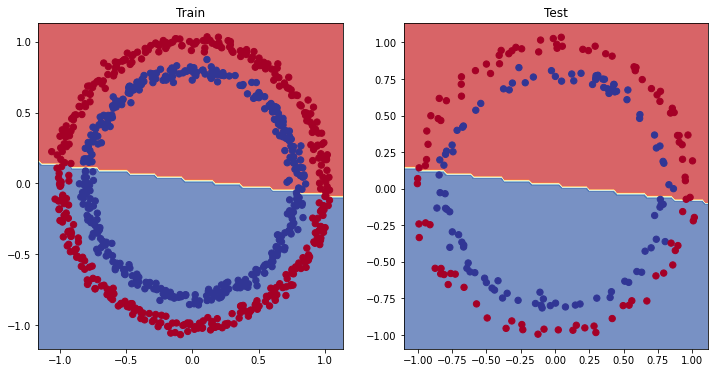

In [29]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0,X_test,y_test)

In [30]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features = 2,out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10,out_features = 10)
    self.layer_3 = nn.Linear(in_features = 10,out_features = 1)

  def forward(self,x):
    return self.layer_3(self.layer_2(self.layer_1(x)))



model_1 = CircleModelV0().to(device)
model_1

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [31]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr=0.1)

In [32]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


epochs = 1000

X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)


for epoch in range(epochs):
      model_1.train()

      y_logits =  model_1(X_train).squeeze()
      y_pred = torch.round(torch.sigmoid(y_logits))

      loss = loss_fn(y_logits,y_train)

      acc = accuracy_fn(y_true = y_train,
                        y_pred = y_pred)
      
      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

      model_1.eval()
      with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))


        test_loss =  loss_fn(test_logits,y_test)
        test_acc =  accuracy_fn(y_true = y_test,
                        y_pred = test_pred)
        

      if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


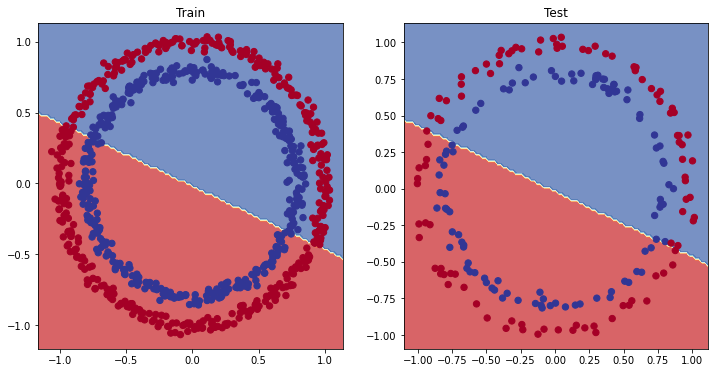

In [33]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_1,X_train,y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_1,X_test,y_test)

In [34]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01
X_regression = torch.arange(start,end,step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

len(X_regression)

100

In [35]:
train_split = int(0.8*len(X_regression))
X_train_regression,y_train_regression = X_regression[:train_split],y_regression[:train_split]
X_test_regression,y_test_regression = X_regression[train_split:],y_regression[train_split:]
len(X_train_regression),len(X_test_regression),len(y_train_regression),len(y_test_regression)

(80, 20, 80, 20)

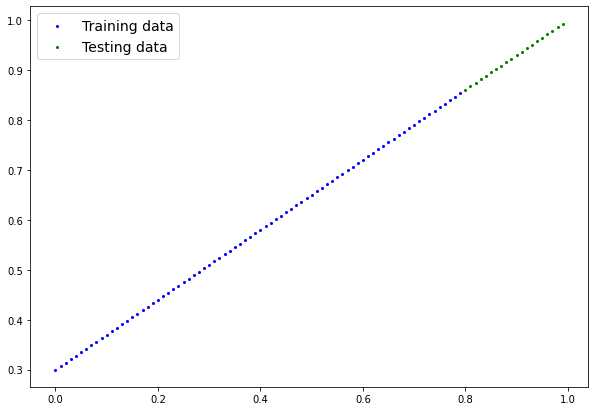

In [36]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

In [37]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [47]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params = model_2.parameters(),
                            lr=0.01)

In [48]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


epochs = 1000

X_train_regression,y_train_regression = X_train_regression.to(device),y_train_regression.to(device)
X_test_regression,y_test_regression = X_test_regression.to(device),y_test_regression.to(device)


for epoch in range(epochs):
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred,y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred,y_test_regression)


  if epoch % 100==0:
    print(f"Epoch: {epoch} | Loss:{loss:.5f} | Test_loss: {test_loss:.5f}")

Epoch: 0 | Loss:0.06466 | Test_loss: 0.12597
Epoch: 100 | Loss:0.00743 | Test_loss: 0.00093
Epoch: 200 | Loss:0.00621 | Test_loss: 0.00123
Epoch: 300 | Loss:0.00619 | Test_loss: 0.00116
Epoch: 400 | Loss:0.00617 | Test_loss: 0.00094
Epoch: 500 | Loss:0.00646 | Test_loss: 0.00138
Epoch: 600 | Loss:0.00614 | Test_loss: 0.00110
Epoch: 700 | Loss:0.00612 | Test_loss: 0.00103
Epoch: 800 | Loss:0.00641 | Test_loss: 0.00149
Epoch: 900 | Loss:0.00639 | Test_loss: 0.00118


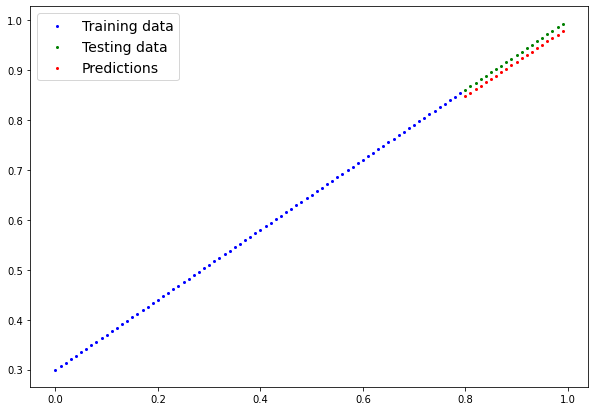

In [52]:
model_2.eval()

with torch.inference_mode():
  y_preds = model_2(X_test_regression)


plot_predictions(train_data=X_train_regression.cpu(),
    train_labels=y_train_regression.cpu(),
    test_data=X_test_regression.cpu(),
    test_labels=y_test_regression.cpu(),
    predictions = y_preds.cpu()
);  